<a href="https://colab.research.google.com/github/JerryChenz/Invest_Proc_Open/blob/main/stock_screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Filters by Listing Location
market = 'HK' #@param ["HK","CN", "US", "JP", "Any"]

# Filters by Business Sector -- df.Sector.unique()
sector = "Real Estate" #@param ["Real Estate", "Consumer Cyclical", "Industrials", "Energy", "Utilities", "Healthcare", "Basic Materials", "Financial Services", "Consumer Defensive", "Technology", "Communication Services", "Any"]

## Step 1: Set inputs

We load the sample dataset from the my github repository, and display the dataset in pandas.

In [ ]:
import pandas as pd
import numpy as np
summary_url = 'https://raw.githubusercontent.com/JerryChenz/Invest_Proc_Open/main/financial_models/Opportunities/Screener/screener_summary.csv'
df = pd.read_csv(summary_url)
# Preparing the data
df['Last_fy'] = pd.to_datetime(df['Last_fy'])
# Missing Forex_rate
mop_hkd = (df["Price_currency"] == "HKD") & (df["Reporting_Currency"] == "MOP")
twd_hkd = (df["Price_currency"] == "HKD") & (df["Reporting_Currency"] == "TWD")
twd_usd = (df["Price_currency"] == "USD") & (df["Reporting_Currency"] == "TWD")
df.loc[mop_hkd, "Fx_rate"] = 0.98
df.loc[mop_hkd, "Fx_rate"] = 0.26
df.loc[twd_usd, "Fx_rate"] = 7.81
# exclude minor countries
df = df[df['Fx_rate'].notna()]
df = df.fillna(0)
df = df[
        ['Ticker', 'Name', 'Sector','Exchange', 'Price', 'Price_currency', 'Shares', 'Reporting_Currency', 'Fx_rate',
         'Dividend', 'Buyback', 'Last_fy', 'TotalAssets', 'CurrentAssets', 'CurrentLiabilities',
         'CurrentDebtAndCapitalLeaseObligation', 'CurrentCapitalLeaseObligation',
         'LongTermDebtAndCapitalLeaseObligation', 'LongTermCapitalLeaseObligation',
         'TotalEquityGrossMinorityInterest', 'MinorityInterest', 'CashAndCashEquivalents',
         'OtherShortTermInvestments', 'InvestmentProperties', 'LongTermEquityInvestment',
         'InvestmentinFinancialAssets', 'NetPPE', 'TotalRevenue', 'Avg_sales_growth', 'CostOfRevenue',
         'GrossMargin', 'Avg_Gross_margin', 'SellingGeneralAndAdministration',
         'EBIT', 'EbitMargin','CFO', 'CFI', 'CFF', 'Avg_ebit_margin', 'Avg_ebit_growth', 'InterestExpense',
         'NetIncomeCommonStockholders', 'NetMargin', 'Avg_net_margin', 'Avg_NetIncome_growth',
         'Years_of_data']]
display(df[['Ticker', 'Name', 'Sector','Exchange', 'Price', 'Price_currency', 'Dividend', 'Buyback']])

,Ticker,Name,Sector,Exchange,Price,Price_currency,Dividend,Buyback
0,000036.SZ,CHINA UNION HOLD L,Real Estate,SHZ,4.030000,CNY,0.000000,0.000000
1,000045.SZ,SHN TEXTILE HLDGS,Consumer Cyclical,SHZ,10.990000,CNY,0.000000,0.000000
2,000088.SZ,SHN YAN TIAN PORT,Industrials,SHZ,5.410000,CNY,0.000000,0.000000
3,000096.SZ,SHENZHEN GUANGJU E,Energy,SHZ,8.370000,CNY,0.000000,0.000000
4,000099.SZ,CITIC OFFSHORE HEL,Industrials,SHZ,7.440000,CNY,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2895,ZD,"Ziff Davis, Inc.",Communication Services,NMS,89.620003,USD,0.000000,1.659766
2896,ZG,"Zillow Group, Inc.",Communication Services,NMS,43.250000,USD,0.000000,5.194365
2897,ZIM,ZIM Integrated Shipping Service,Industrials,NYQ,18.610001,USD,4.468150,0.000000
2898,ZTO,ZTO Express (Cayman) Inc.,Industrials,NYQ,29.110001,USD,1.672118,4.705978


In [ ]:
"""0. Definitions"""
# capitalization in reporting currency
capitalization_price = df['Price'] * df['Shares']
capitalization_report = capitalization_price / df['Fx_rate']
# dividend rate & buyback rate
dividend_rate = df['Dividend'] / df['Price']
buyback_rate = df['Buyback'] / df['Price']
# Capital Structure related
total_debt = df['CurrentDebtAndCapitalLeaseObligation'] + df['LongTermDebtAndCapitalLeaseObligation']
common_equity = df['TotalEquityGrossMinorityInterest'] - df['MinorityInterest']
net_working_capital = np.where((df['CurrentAssets'] == 0) & (df['CurrentLiabilities'] == 0), common_equity, df['CurrentAssets'] - df['CurrentLiabilities'])
excess_cash = np.where(net_working_capital >= df['CashAndCashEquivalents'], df['CashAndCashEquivalents'], net_working_capital)
# Operating assets and liabilities
op_assets = df['TotalAssets'] - df['CashAndCashEquivalents']
op_liabilities = df['TotalAssets'] - df['TotalEquityGrossMinorityInterest'] - total_debt
net_op_assets = op_assets - op_liabilities
# Non-operating assets
current_financial_assets = df['OtherShortTermInvestments'] + df['InvestmentinFinancialAssets']

"""1. Stability Ratios"""
# liquidity_coverage_ratio
core_lcr = df['CashAndCashEquivalents'] / df['CurrentLiabilities']
lcr = (df['CashAndCashEquivalents'] + current_financial_assets) / df['CurrentLiabilities']
# leverage ratio
current_ratio = df['CurrentAssets'] / df['CurrentLiabilities']
debt_ratio = total_debt / common_equity
# Accrual anomaly - Scaled Total Accruals
# sta = (df['NetIncomeCommonStockholders'] - df['CFO']) / df['TotalAssets']
# Scaled Net Operating Assets
sona = net_op_assets / df['TotalAssets']
# Todo: Dr. Messod Beneish's PROBM model

"""2. Quality Ratios: """
ppe_multiple = df['NetPPE'] / df['TotalRevenue']
greenblatt_capital = df['NetPPE'] + net_working_capital - df['CashAndCashEquivalents']  # Not consider capital structure
greenblatt_roc = df['EBIT'] / greenblatt_capital

df['ROC'] = greenblatt_roc
df['lcr'] = lcr
df['core_lcr'] = core_lcr
df['Debt ratio'] = debt_ratio
df['Current ratio'] = current_ratio
df['Dividend rate'] = dividend_rate
df['Buyback rate'] = buyback_rate
df['PPE_multiple'] = ppe_multiple

In [ ]:
if market == 'HK':
  exchange_condition = df['Exchange'] == 'HKG'
elif market == 'CN':
  exchange_condition = (df['Exchange'] == 'SHZ') | (df['Exchange'] == 'SHH')
elif market == 'US':
  exchange_condition = (df['Exchange'] == 'NMS') | (df['Exchange'] == 'NYQ')
elif market == 'JP':
  exchange_condition = (df['Exchange'] == 'JPX')
else:
  exchange_condition = (df['Exchange'] != '')

if sector == 'Any':
  sector_condition = (df['Sector'] != '')
else:
  sector_condition = (df['Sector'] == sector)

df = df.loc[exchange_condition & sector_condition]

# Step 2: Pre-screening

We can screen using different sets of conditions, then merge them later.

In [ ]:
# Unfiltered Data
display(df[['Ticker', 'Name', 'Price', 'Price_currency', 'Dividend rate', 'Buyback rate', 'Avg_sales_growth', 'Avg_Gross_margin', 'Avg_ebit_margin', 'ROC', 'lcr' ,'core_lcr', 'Current ratio', 'Debt ratio']])

,Ticker,Name,Price,Price_currency,Dividend rate,Buyback rate,Avg_sales_growth,Avg_Gross_margin,Avg_ebit_margin,ROC,lcr,core_lcr,Current ratio,Debt ratio
8,0004.HK,WHARF HOLDINGS,21.150000,HKD,0.000000,0.000000,15.51,41.130000,49.563333,0.453281,0.474061,0.474061,1.683942,0.180803
72,0010.HK,HANG LUNG GROUP,14.740000,HKD,0.056984,0.000000,7.79,27.723333,66.236667,4.742084,0.396345,0.396345,1.487782,0.283735
74,0012.HK,HENDERSON LAND,30.049999,HKD,0.059908,0.000000,-1.26,44.846667,42.070000,0.143417,0.358662,0.211826,2.102098,0.278153
95,0014.HK,HYSAN DEV,27.049999,HKD,0.053886,0.005255,-4.86,13.493333,79.320000,0.926471,2.494026,0.161668,1.776396,0.315590
96,0016.HK,SHK PPT,113.300003,HKD,0.043686,0.000079,-2.92,48.175000,42.732500,0.154602,0.385581,0.325814,4.002341,0.208938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209,9928.HK,TIMES NEIGHBOR,1.200000,HKD,0.000000,0.000000,58.64,71.430000,16.420000,0.798157,0.555830,0.555830,1.939491,0.009485
2220,9979.HK,GREENTOWN MGMT,6.800000,HKD,0.024329,0.000000,7.33,53.880000,29.976667,-3.336417,0.935933,0.851814,1.678311,0.004729
2221,9982.HK,CENTRALCHINA MT,0.860000,HKD,0.083530,0.002462,12.46,0.000000,97.280000,7.075249,4.388903,4.379948,5.737879,0.002025
2222,9983.HK,CC NEW LIFE,3.620000,HKD,0.073630,0.001759,43.44,67.283333,23.756667,1.101823,1.086418,1.059568,2.453578,0.039020


In [ ]:
# common fitlering conditions: 
# 1. Reasonable leverage and Good Liqudity
common_1 = (core_lcr >= 0.2) & (lcr >= 0.6)
common_2 = (current_ratio >= 0.8) & (debt_ratio <= 0.8)
common_3 = (total_debt / df['CurrentAssets']) < 1.5
# 2. Avoid negative gross margin and value trap
common_4 = capitalization_price > 1000000000
common_5 = (capitalization_price > 6000000000) & (df['Avg_Gross_margin'] > 0.01)
common_6 = (capitalization_price <= 6000000000) & ((dividend_rate > 0.01) | (buyback_rate > 0.01))

# filtered by common conditions
common_df = df
common_df = common_df.loc[common_1 & common_2 & common_3 & common_4 & (common_5 | common_6)]
display(common_df.loc[:, ['Ticker', 'Name', 'Price', 'Price_currency', 'Dividend rate', 'Buyback rate', 'Avg_sales_growth', 'Avg_Gross_margin', 'Avg_ebit_margin', 'ROC', 'lcr' ,'core_lcr', 'Current ratio', 'Debt ratio']])

,Ticker,Name,Price,Price_currency,Dividend rate,Buyback rate,Avg_sales_growth,Avg_Gross_margin,Avg_ebit_margin,ROC,lcr,core_lcr,Current ratio,Debt ratio
97,0017.HK,NEW WORLD DEV,24.600000,HKD,0.000000,0.015617,-2.51,69.700000,16.967500,-0.689424,0.751488,0.333978,1.117786,0.690958
184,0026.HK,CHINA MOTOR BUS,72.449997,HKD,0.043720,0.000000,-6.19,5.432500,84.690000,1.018063,66.629605,34.139193,34.227015,0.000000
258,0071.HK,MIRAMAR HOTEL,12.400000,HKD,0.000000,0.000000,-31.10,53.036667,44.506667,-4.270619,7.584353,7.464791,7.972771,0.003201
262,0083.HK,SINO LAND,10.400000,HKD,0.036424,0.000000,84.60,44.285000,46.987500,0.136724,3.029791,0.237880,4.728685,0.032226
305,0173.HK,K. WAH INT'L,3.000000,HKD,0.000000,0.000000,24.19,54.006667,41.556667,0.491154,0.948908,0.439469,2.064249,0.325166
314,0194.HK,LIU CHONG HING,7.400000,HKD,0.058108,0.000000,-15.66,43.176667,32.000000,0.095299,1.465675,1.185430,2.620671,0.164369
341,0258.HK,TOMSON GROUP,1.700000,HKD,0.032353,0.000000,-7.34,32.563333,35.060000,0.250407,0.886942,0.813433,2.127416,0.021907
477,0606.HK,SCE CM,2.100000,HKD,0.022477,0.000000,46.46,57.183333,32.976667,-0.816947,4.680639,4.680639,4.920236,0.001095
501,0683.HK,KERRY PPT,20.500000,HKD,0.178686,0.001358,-6.95,45.126667,43.850000,0.149003,0.913698,0.805098,2.888401,0.449716
580,0873.HK,SHIMAO SERVICES,3.230000,HKD,0.000000,0.008331,83.96,68.763333,21.736667,-1.587572,0.865164,0.863452,1.531420,0.368584


#Step 3. Screening

Filter the dataset using the above conditions

In [ ]:
# 1st set of conditions: Stability
asset_1 = (core_lcr >= 0.8) & (lcr >= 0.9)
asset_2 = (dividend_rate > 0.01) | (buyback_rate > 0.01)
asset_3 = (current_ratio >= 1) & (debt_ratio <= 0.5)

# filtered by 1st set of conditions: Stability
asset_df = common_df
asset_df['is_Asset'] = True
asset_df = asset_df.loc[asset_1 & asset_2 & asset_3]
display(asset_df.loc[:, ['Ticker', 'Name', 'Price', 'Price_currency', 'Dividend rate', 'Buyback rate', 'ROC', 'Avg_sales_growth', 'Avg_Gross_margin', 'Avg_ebit_margin', 'lcr' ,'core_lcr', 'Current ratio', 'Debt ratio']])

<ipython-input-103-e05238a0fae5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_df['is_Asset'] = True


,Ticker,Name,Price,Price_currency,Dividend rate,Buyback rate,ROC,Avg_sales_growth,Avg_Gross_margin,Avg_ebit_margin,lcr,core_lcr,Current ratio,Debt ratio
184,0026.HK,CHINA MOTOR BUS,72.449997,HKD,0.043720,0.000000,1.018063,-6.19,5.432500,84.690000,66.629605,34.139193,34.227015,0.000000
314,0194.HK,LIU CHONG HING,7.400000,HKD,0.058108,0.000000,0.095299,-15.66,43.176667,32.000000,1.465675,1.185430,2.620671,0.164369
477,0606.HK,SCE CM,2.100000,HKD,0.022477,0.000000,-0.816947,46.46,57.183333,32.976667,4.680639,4.680639,4.920236,0.001095
501,0683.HK,KERRY PPT,20.500000,HKD,0.178686,0.001358,0.149003,-6.95,45.126667,43.850000,0.913698,0.805098,2.888401,0.449716
667,1113.HK,CK ASSET,50.349998,HKD,0.000000,0.107990,0.217290,-11.79,46.740000,53.260000,1.318944,1.318944,4.297657,0.130649
791,1516.HK,SUNAC SERVICES,4.370000,HKD,0.000000,0.020187,5.591689,67.24,71.803333,20.013333,1.074305,0.928148,1.955115,0.014884
1444,3316.HK,BINJIANG SER,24.700001,HKD,0.032023,0.000000,-1.099656,41.25,69.610000,24.823333,1.285909,1.014911,1.685223,0.001180
1916,6626.HK,YUEXIU SERVICES,4.580000,HKD,0.012940,0.000000,-0.638072,47.28,67.780000,28.166667,2.264989,2.247855,2.760039,0.019334
2178,9666.HK,JINKE SERVICES,14.580000,HKD,0.034324,0.000000,0.454038,61.00,70.686667,23.740000,1.593463,1.573082,3.537193,0.032496
2220,9979.HK,GREENTOWN MGMT,6.800000,HKD,0.024329,0.000000,-3.336417,7.33,53.880000,29.976667,0.935933,0.851814,1.678311,0.004729


<ipython-input-104-ed5c3d48cbea>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Stalwart_df['is_Stalwart'] = True


,Ticker,Name,Price,Price_currency,Dividend rate,Buyback rate,Avg_sales_growth,Avg_Gross_margin,Avg_ebit_margin,ROC,lcr,core_lcr,Current ratio,Debt ratio
262,0083.HK,SINO LAND,10.400000,HKD,0.036424,0.000000,84.60,44.285000,46.987500,0.136724,3.029791,0.237880,4.728685,0.032226
305,0173.HK,K. WAH INT'L,3.000000,HKD,0.000000,0.000000,24.19,54.006667,41.556667,0.491154,0.948908,0.439469,2.064249,0.325166
791,1516.HK,SUNAC SERVICES,4.370000,HKD,0.000000,0.020187,67.24,71.803333,20.013333,5.591689,1.074305,0.928148,1.955115,0.014884
1446,3319.HK,A-LIVING,10.700000,HKD,0.000000,0.000000,67.99,68.716667,24.826667,0.930996,0.777543,0.515131,1.845668,0.010298
1867,6098.HK,CG SERVICES,22.799999,HKD,0.000000,0.007724,73.32,67.883333,19.096667,8.691026,0.702881,0.371125,1.328982,0.081230
2178,9666.HK,JINKE SERVICES,14.580000,HKD,0.034324,0.000000,61.00,70.686667,23.740000,0.454038,1.593463,1.573082,3.537193,0.032496
2222,9983.HK,CC NEW LIFE,3.620000,HKD,0.073630,0.001759,43.44,67.283333,23.756667,1.101823,1.086418,1.059568,2.453578,0.039020


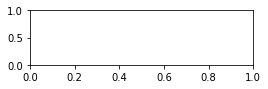

In [ ]:
# 2nd set of conditions: Stalwart
stalwart_1 = (df['Avg_Gross_margin'] > 10) & (df['Avg_ebit_margin'] > 15)
stalwart_2 = df['Avg_sales_growth'] >= -0.10
stalwart_3 = greenblatt_roc > 0.03

# fitlered by 2nd set of conditions: Stalwart
Stalwart_df = common_df
Stalwart_df['is_Stalwart'] = True
Stalwart_df = Stalwart_df.loc[stalwart_1 & stalwart_2 & stalwart_3]
display(Stalwart_df.loc[:, ['Ticker', 'Name', 'Price', 'Price_currency', 'Dividend rate', 'Buyback rate', 'Avg_sales_growth', 'Avg_Gross_margin', 'Avg_ebit_margin', 'ROC', 'lcr' ,'core_lcr', 'Current ratio', 'Debt ratio']])

In [ ]:
# combine the results
result_set = pd.concat([Stalwart_df, asset_df])

"""Price Ratios: """
nonop_noncash_assets = 0.9 * (df['InvestmentProperties'] + df['LongTermEquityInvestment']) + current_financial_assets
enterprise_value = capitalization_report + total_debt + df['MinorityInterest'] - excess_cash - nonop_noncash_assets
ebit_tev = df['EBIT'] / enterprise_value
result_set['EV'] = enterprise_value # may need to update the price
result_set['EBIT/EV'] = ebit_tev

# Sort the set
result_set = result_set.groupby("Ticker").first().sort_values('EV')

# find the subset of Asset_play and Stalwart
is_asset_stalwart = [result_set['is_Asset'].eq(True) & result_set['is_Stalwart'].eq(True)]
result_set['A_S'] = np.select(is_asset_stalwart, [True], default='')

display(result_set[['Name', 'Sector', 'Price', 'Dividend rate', 'Buyback rate', 'EV', 'EBIT/EV', 'ROC', 'Avg_sales_growth', 'Avg_Gross_margin', 'Avg_ebit_margin', 'lcr' ,'core_lcr', 'Current ratio', 'Debt ratio', 'A_S']])

,Name,Sector,Price,Dividend rate,Buyback rate,EV,EBIT/EV,ROC,Avg_sales_growth,Avg_Gross_margin,Avg_ebit_margin,lcr,core_lcr,Current ratio,Debt ratio,A_S
Ticker,,,,,,,,,,,,,,,,
0683.HK,KERRY PPT,Real Estate,20.500000,0.178686,0.001358,-4.772002e+10,-0.141233,0.149003,-6.95,45.126667,43.850000,0.913698,0.805098,2.888401,0.449716,
0083.HK,SINO LAND,Real Estate,10.400000,0.036424,0.000000,-3.530635e+10,-0.209164,0.136724,84.60,44.285000,46.987500,3.029791,0.237880,4.728685,0.032226,True
0173.HK,K. WAH INT'L,Real Estate,3.000000,0.000000,0.000000,-1.750143e+10,-0.280122,0.491154,24.19,54.006667,41.556667,0.948908,0.439469,2.064249,0.325166,True
1113.HK,CK ASSET,Real Estate,50.349998,0.000000,0.107990,-1.178362e+10,-2.957834,0.217290,-11.79,46.740000,53.260000,1.318944,1.318944,4.297657,0.130649,
0194.HK,LIU CHONG HING,Real Estate,7.400000,0.058108,0.000000,-6.337609e+09,-0.037459,0.095299,-15.66,43.176667,32.000000,1.465675,1.185430,2.620671,0.164369,
0026.HK,CHINA MOTOR BUS,Real Estate,72.449997,0.043720,0.000000,-5.308980e+09,-0.010882,1.018063,-6.19,5.432500,84.690000,66.629605,34.139193,34.227015,0.000000,
9982.HK,CENTRALCHINA MT,Real Estate,0.860000,0.083530,0.002462,3.987942e+08,3.214034,7.075249,12.46,0.000000,97.280000,4.388903,4.379948,5.737879,0.002025,
0606.HK,SCE CM,Real Estate,2.100000,0.022477,0.000000,1.214475e+09,0.296434,-0.816947,46.46,57.183333,32.976667,4.680639,4.680639,4.920236,0.001095,
9983.HK,CC NEW LIFE,Real Estate,3.620000,0.073630,0.001759,2.103036e+09,0.426271,1.101823,43.44,67.283333,23.756667,1.086418,1.059568,2.453578,0.039020,True


In [ ]:
display_set = result_set.loc[result_set['A_S'] != '']
display(display_set[['Name', 'Sector', 'Price', 'Dividend rate', 'Buyback rate', 'EV', 'EBIT/EV', 'ROC', 'Avg_sales_growth', 'Avg_Gross_margin', 'Avg_ebit_margin', 'lcr' ,'core_lcr', 'Current ratio', 'Debt ratio']])

,Name,Sector,Price,Dividend rate,Buyback rate,EV,EBIT/EV,ROC,Avg_sales_growth,Avg_Gross_margin,Avg_ebit_margin,lcr,core_lcr,Current ratio,Debt ratio
Ticker,,,,,,,,,,,,,,,
0083.HK,SINO LAND,Real Estate,10.400000,0.036424,0.000000,-3.530635e+10,-0.209164,0.136724,84.60,44.285000,46.987500,3.029791,0.237880,4.728685,0.032226
0173.HK,K. WAH INT'L,Real Estate,3.000000,0.000000,0.000000,-1.750143e+10,-0.280122,0.491154,24.19,54.006667,41.556667,0.948908,0.439469,2.064249,0.325166
9983.HK,CC NEW LIFE,Real Estate,3.620000,0.073630,0.001759,2.103036e+09,0.426271,1.101823,43.44,67.283333,23.756667,1.086418,1.059568,2.453578,0.039020
9666.HK,JINKE SERVICES,Real Estate,14.580000,0.034324,0.000000,4.463012e+09,0.305191,0.454038,61.00,70.686667,23.740000,1.593463,1.573082,3.537193,0.032496
3319.HK,A-LIVING,Real Estate,10.700000,0.000000,0.000000,6.016568e+09,0.490143,0.930996,67.99,68.716667,24.826667,0.777543,0.515131,1.845668,0.010298
1516.HK,SUNAC SERVICES,Real Estate,4.370000,0.000000,0.020187,7.033152e+09,0.237881,5.591689,67.24,71.803333,20.013333,1.074305,0.928148,1.955115,0.014884
6098.HK,CG SERVICES,Real Estate,22.799999,0.000000,0.007724,5.278795e+10,0.099776,8.691026,73.32,67.883333,19.096667,0.702881,0.371125,1.328982,0.081230


In [ ]:
# Export the screen result to csv file
export = 'Yes' #@param ["Yes","No"]
simplified = 'No' #@param ["Yes","No"]

if export == "Yes":
  from google.colab import files
  csv_name = "Screener_result.csv"
  if simplified == "Yes":
    result_set[['Name', 'Sector', 'Price', 'Dividend rate', 'Buyback rate', 'EV', 'EBIT/EV', 'ROC', 'Avg_sales_growth', 'Avg_Gross_margin', 'Avg_ebit_margin', 'lcr' ,'core_lcr', 'Current ratio', 'Debt ratio', 'A_S']].to_csv(csv_name)
  else:
    csv_name = f"Raw_{csv_name}"
    result_set.to_csv(csv_name)
  files.download(csv_name)
print("***End of the Screener***")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***End of the Screener***
